In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow
import mlflow.sklearn

In [22]:
import os
import librosa
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve,
    auc,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize




import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from joblib import Parallel, delayed



from utils import load_config
from models.baseline import preprocess_data

In [4]:
config       = load_config()
features_dir = config['data_paths']['features']
features_csv = os.path.join(features_dir, 'all_features.csv')

### Load features

In [5]:
features_df = pd.read_csv(features_csv)
features_df.head()

,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_25th_percentile,spectral_centroid_50th_percentile,...,shimmer_dda,hnr,voicedcount,npause,originaldur,intensity_duration,speakingrate,articulationrate,asd,totalpauseduration
0,LJ028-0143,WF1,1874.133940,1345.530923,1.810453e+06,526.534014,6285.029512,5758.495498,975.050304,1345.562364,...,0.099888,11.673236,32.0,2.0,7.360726,7.360726,4.347397,4.925558,0.203023,0.864
1,LJ028-0143,WF2,1896.024231,1357.514810,1.842846e+06,585.883222,6304.308256,5718.425035,985.413912,1390.383399,...,0.096005,12.024721,29.0,2.0,7.360726,7.360726,3.939829,4.463787,0.224025,0.864
2,LJ028-0143,WF3,1918.827899,1370.524166,1.878336e+06,550.249874,6265.837711,5715.587837,1007.631444,1414.627604,...,0.111386,11.691639,30.0,2.0,7.349116,7.349116,4.082124,4.614593,0.216704,0.848
3,LJ028-0143,WF4,1871.877706,1335.658077,1.783982e+06,515.918819,6277.746003,5761.827184,974.725797,1356.723998,...,0.088301,12.341544,33.0,2.0,7.360726,7.360726,4.483254,5.079482,0.196870,0.864
4,LJ028-0143,WF5,1939.824198,1358.239585,1.844815e+06,555.707767,6259.423582,5703.715815,1010.880341,1418.982549,...,0.109853,11.311680,32.0,2.0,7.360726,7.360726,4.347397,4.925558,0.203023,0.864


In [6]:
selected_features = ['spectral_contrast_var', 'spectral_contrast_range', 'spectral_contrast_mean', 'F3_mean', 'F2_stdev', 'F3_stdev', 'F1_stdev', 'mfcc_13_std', 'F2_mean', 'mfcc_6_75th_percentile', 'mfcc_12_75th_percentile', 'mfcc_9_75th_percentile', 'mfcc_3_75th_percentile', 'mfcc_12_50th_percentile', 'mfcc_9_50th_percentile', 'mfcc_2_50th_percentile', 'mfcc_5_50th_percentile', 'mfcc_7_50th_percentile', 'f0_skew', 'pause_std', 'asd', 'pause_75th_percentile', 'chroma_11_50th_percentile', 'chroma_3_50th_percentile', 'chroma_6_50th_percentile', 'spectral_flux_skew', 'mfcc_12_25th_percentile', 'mfcc_6_25th_percentile', 'mfcc_2_25th_percentile', 'spectral_bandwidth_min', 'zero_crossing_rate_skew', 'chroma_1_range', 'speaking_rate', 'chroma_12_range', 'chroma_2_range', 'chroma_3_range', 'chroma_5_range', 'chroma_10_range', 'spectral_flatness_skew', 'chroma_6_range', 'chroma_8_range', 'chroma_7_range', 'chroma_9_range', 'f0_kurtosis', 'chroma_11_range', 'spectral_bandwidth_kurtosis', 'chroma_6_max', 'chroma_10_max', 'chroma_2_max', 'chroma_12_max', 'chroma_5_max', 'chroma_7_max', 'chroma_4_max', 'chroma_1_max', 'chroma_11_max', 'chroma_4_std', 'chroma_6_std', 'chroma_7_std', 'chroma_3_max', 'chroma_12_std', 'chroma_11_std', 'chroma_2_std', 'chroma_10_std', 'chroma_3_std', 'chroma_9_std', 'chroma_8_std', 'chroma_5_std', 'chroma_1_std', 'zero_crossing_rate_range', 'mfcc_1_skew', 'spectral_rolloff_range', 'f0_25th_percentile', 'pause_skew', 'chroma_9_min', 'mfcc_13_mean', 'mfcc_11_mean', 'zero_crossing_rate_min', 'spectral_bandwidth_max', 'mfcc_10_max', 'f0_75th_percentile', 'mfcc_5_max', 'mfcc_6_mean', 'mfcc_3_max', 'jitter_local', 'spectral_flux_25th_percentile', 'spectral_flatness_min', 'energy_min', 'shimmer_local', 'spectral_flatness_range']
features_df = features_df[['audio_id'] + selected_features + ['real_or_fake']].copy()

In [9]:
labels_sorted = ['R'] + [label for label in sorted(features_df['real_or_fake'].unique()) if label != 'R']
label_mapping = {label: idx for idx, label in enumerate(labels_sorted)}
features_df['target'] = features_df['real_or_fake'].map(label_mapping)

{'R': 0,
 'F01': 1,
 'F02': 2,
 'F03': 3,
 'F04': 4,
 'F05': 5,
 'F06': 6,
 'WF1': 7,
 'WF2': 8,
 'WF3': 9,
 'WF4': 10,
 'WF5': 11,
 'WF6': 12,
 'WF7': 13}

In [10]:
mlflow.set_tracking_uri("http://mlflow:5001")

In [11]:
mlflow.set_experiment('model_training')

<Experiment: artifact_location='mlflow-artifacts:/213449315161875335', creation_time=1723415957368, experiment_id='213449315161875335', last_update_time=1723415957368, lifecycle_stage='active', name='model_training', tags={}>

In [13]:
features_columns = [col for col in features_df.columns if col not in ['audio_id', 'real_or_fake', 'target']]
X = features_df[features_columns]
X = preprocess_data(X)
y = features_df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
X_train.shape, X_test.shape

((280702, 89), (70176, 89))

In [19]:
def train_eval_model(model, model_name, X_train, X_test, y_train, y_test, classes):
    run_name = f"{model_name}_MultiClass_Run"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("model", model_name)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)

        # Binarize the output for multi-class ROC AUC
        y_test_binarized = label_binarize(y_test, classes=classes)
        if y_test_binarized.shape[1] == 1:  # only one class present in y_test
            y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='macro')
        recall = recall_score(y_test, predictions, average='macro')
        f1 = f1_score(y_test, predictions, average='macro')
        roc_auc = roc_auc_score(y_test_binarized, probabilities, multi_class='ovr')

        # Log metrics
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        })

        # Save and log classification report as text file
        report = classification_report(y_test, predictions)
        with open("classification_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact("classification_report.txt")

        # Plot and log confusion matrix as an image
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        confusion_matrix_path = "confusion_matrix.png"
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)
        plt.close()

        # ROC Curve for each class
        fig, ax = plt.subplots()
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
            ax.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (area = {auc(fpr, tpr):.2f})')
        plt.title('Multiclass ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="best")
        mlflow.log_figure(fig, "roc_curve.png")
        plt.close(fig)

        print(f"Run Name: {run_name} | Model: {model_name} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | ROC AUC: {roc_auc:.4f}")


In [23]:
# Define the classes array based on your dataset
classes = np.unique(y)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
train_eval_model(log_reg, "Logistic_Regression", X_train, X_test, y_train, y_test, classes)

2024/08/12 00:09:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic_Regression_MultiClass_Run at: http://mlflow:5001/#/experiments/213449315161875335/runs/5c701379fb8c41b59ec325f464b7937b.
2024/08/12 00:09:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/213449315161875335.


Run Name: Logistic_Regression_MultiClass_Run | Model: Logistic_Regression | Accuracy: 0.7015 | Precision: 0.6509 | Recall: 0.6568 | F1 Score: 0.6524 | ROC AUC: 0.9717


In [24]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
train_eval_model(random_forest, "Random_Forest", X_train, X_test, y_train, y_test, classes)

2024/08/12 00:14:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest_MultiClass_Run at: http://mlflow:5001/#/experiments/213449315161875335/runs/664687970f2c4a65b23027c6eeff9dba.
2024/08/12 00:14:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/213449315161875335.


Run Name: Random_Forest_MultiClass_Run | Model: Random_Forest | Accuracy: 0.5913 | Precision: 0.5344 | Recall: 0.5451 | F1 Score: 0.5371 | ROC AUC: 0.9540


### Model performance of Logistic Regression

In [26]:
# Name of the experiment
experiment_name = "model_training"

# Get the experiment object
experiment = mlflow.get_experiment_by_name(experiment_name)

# Search for logistic regression runs in the experiment
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.mlflow.runName = 'Logistic_Regression_MultiClass_Run'",
    order_by=["start_time desc"],
    max_results=1
)

# Extract the latest run_id
latest_run_id = runs.iloc[0]['run_id'] if not runs.empty else None

latest_run_id

'5c701379fb8c41b59ec325f464b7937b'

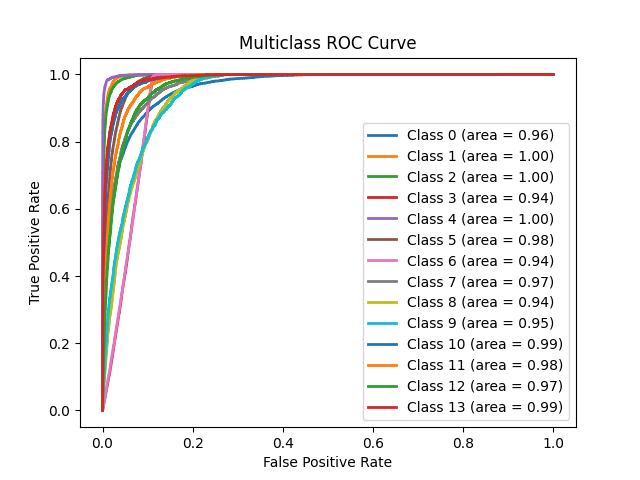

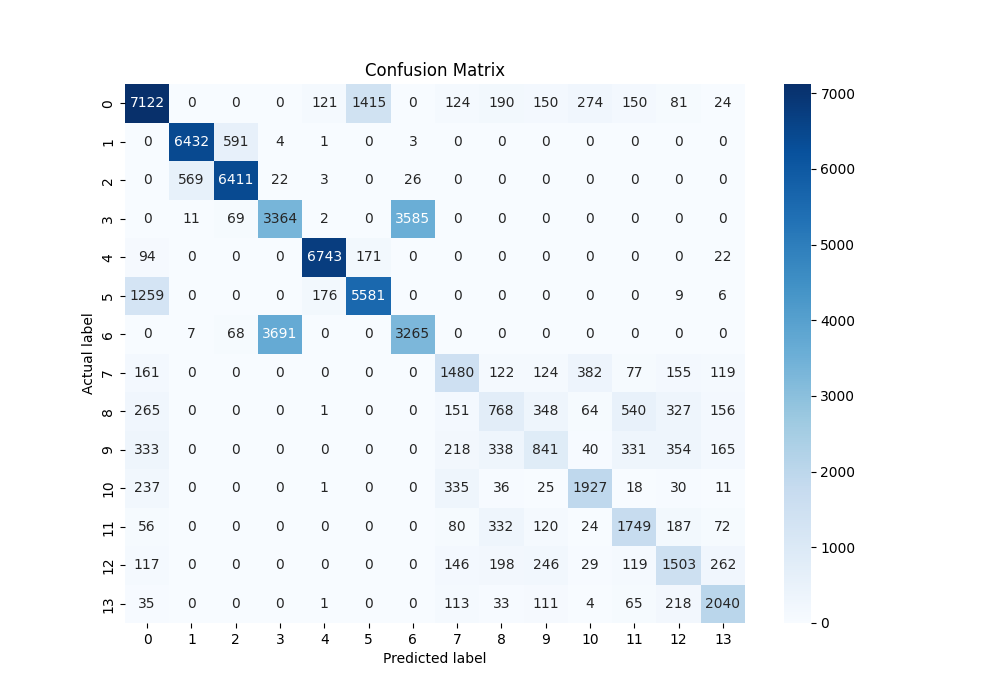

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      9651
           1       0.92      0.91      0.92      7031
           2       0.90      0.91      0.90      7031
           3       0.48      0.48      0.48      7031
           4       0.96      0.96      0.96      7030
           5       0.78      0.79      0.79      7031
           6       0.47      0.46      0.47      7031
           7       0.56      0.56      0.56      2620
           8       0.38      0.29      0.33      2620
           9       0.43      0.32      0.37      2620
          10       0.70      0.74      0.72      2620
          11       0.57      0.67      0.62      2620
          12       0.52      0.57      0.55      2620
          13       0.71      0.78      0.74      2620

    accuracy                           0.70     70176
   macro avg       0.65      0.66      0.65     70176
weighted avg       0.70      0.70      0.70     70176



In [27]:
from IPython.display import display, Image
import os

roc_curve_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/roc_curve.png'
confusion_matrix_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/confusion_matrix.png'
classification_report_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/classification_report.txt'

# Display ROC Curve Image
if os.path.exists(roc_curve_path):
    display(Image(filename=roc_curve_path))
else:
    print("ROC Curve image not found.")

# Display Confusion Matrix Image
if os.path.exists(confusion_matrix_path):
    display(Image(filename=confusion_matrix_path))
else:
    print("Confusion Matrix image not found.")

# Print the Classification Report
if os.path.exists(classification_report_path):
    with open(classification_report_path, 'r') as file:
        classification_report = file.read()
        print("Classification Report:\n", classification_report)
else:
    print("Classification report not found.")


### Model Performance of Random Forest Classifier

In [28]:
# Name of the experiment
experiment_name = "model_training"

# Get the experiment object
experiment = mlflow.get_experiment_by_name(experiment_name)

# Search for logistic regression runs in the experiment
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.mlflow.runName = 'Random_Forest_MultiClass_Run'",
    order_by=["start_time desc"],
    max_results=1
)

# Extract the latest run_id
latest_run_id = runs.iloc[0]['run_id'] if not runs.empty else None

latest_run_id

'664687970f2c4a65b23027c6eeff9dba'

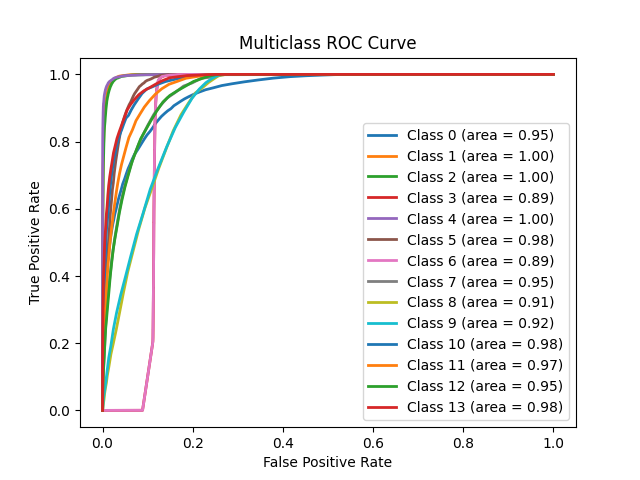

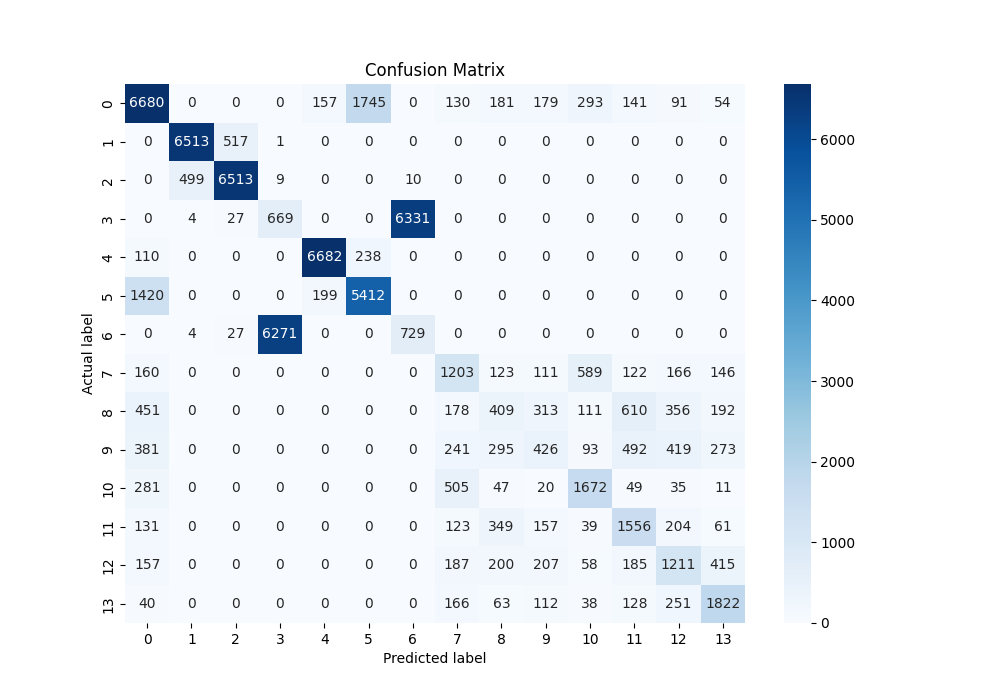

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69      9651
           1       0.93      0.93      0.93      7031
           2       0.92      0.93      0.92      7031
           3       0.10      0.10      0.10      7031
           4       0.95      0.95      0.95      7030
           5       0.73      0.77      0.75      7031
           6       0.10      0.10      0.10      7031
           7       0.44      0.46      0.45      2620
           8       0.25      0.16      0.19      2620
           9       0.28      0.16      0.21      2620
          10       0.58      0.64      0.61      2620
          11       0.47      0.59      0.53      2620
          12       0.44      0.46      0.45      2620
          13       0.61      0.70      0.65      2620

    accuracy                           0.59     70176
   macro avg       0.53      0.55      0.54     70176
weighted avg       0.58      0.59      0.59     70176



In [29]:
from IPython.display import display, Image
import os

roc_curve_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/roc_curve.png'
confusion_matrix_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/confusion_matrix.png'
classification_report_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/classification_report.txt'

# Display ROC Curve Image
if os.path.exists(roc_curve_path):
    display(Image(filename=roc_curve_path))
else:
    print("ROC Curve image not found.")

# Display Confusion Matrix Image
if os.path.exists(confusion_matrix_path):
    display(Image(filename=confusion_matrix_path))
else:
    print("Confusion Matrix image not found.")

# Print the Classification Report
if os.path.exists(classification_report_path):
    with open(classification_report_path, 'r') as file:
        classification_report = file.read()
        print("Classification Report:\n", classification_report)
else:
    print("Classification report not found.")
